# Notebook Example

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/worldbank/GEE_Zonal/blob/main/docs/examples/zonal_statistics_example.ipynb)

In [ ]:
# !pip install gee_zonal

In [ ]:
# !pip install pyarrow fsspec s3fs matplotlib folium mapclassify

In [ ]:
# !pip install plotnine

In [1]:
from gee_zonal import ZonalStats
import ee
import geopandas as gpd
import pandas as pd

## Input Features

Input target features can be referenced directly as a GEE asset, or can be supplied
as a ``geopandas.GeoDataFrame``, or a path to a shapefile/GeoJSON (will be automatically
converted to ``ee.FeatureCollection``).

In [3]:
ftw = "s3://us-west-2.opendata.source.coop/kerner-lab/fields-of-the-world-kenya/boundaries_kenya_2022.parquet"
gdf = gpd.read_parquet(ftw, storage_options={"anon": True})

In [7]:
gdf.head(50).explore()

## Initialize Zonal Stats

### Option A: Retrieve results directly   
Output: DataFrame with statistics  
*Recommended for small areas / low n*

In [8]:
AOIs = gdf.head(50)

In [1]:
# ZonalStats?

In [10]:
zs = ZonalStats(
    target_features=AOIs,
    statistic_type="mean",
    collection_id="MODIS/061/MYD13Q1",
    band="EVI",
    frequency="original",
    scale=250,
    start_year=2023,
    end_year=2025,
    scale_factor=0.0001,
)

In [11]:
res = zs.runZonalStats()
res.head()

,2023_01_09_EVI,2023_01_25_EVI,2023_02_10_EVI,2023_02_26_EVI,2023_03_14_EVI,2023_03_30_EVI,2023_04_15_EVI,2023_05_01_EVI,2023_05_17_EVI,2023_06_02_EVI,...,2024_12_10_EVI,2024_12_26_EVI,2025_01_09_EVI,2025_01_25_EVI,2025_02_10_EVI,2025_02_26_EVI,2025_03_14_EVI,crop_name,determination_datetime,id
0,0.279700,0.248700,0.1906,0.151100,0.158600,0.263800,0.449600,0.465700,0.402900,0.415700,...,0.320000,0.353500,0.320500,0.223500,0.224000,0.216600,0.223200,Maize,"{'type': 'Date', 'value': 1646006400000}",322cb629-8921-4510-bf7f-70e99882f0a8
1,0.328100,0.294500,0.2524,0.215400,0.244500,0.355600,0.426000,0.504200,0.444800,0.367300,...,0.368800,0.400700,0.419900,0.376100,0.349900,0.269700,0.253600,Sorghum,"{'type': 'Date', 'value': 1646006400000}",097d2b8a-7199-41db-8fb1-11e7fd76ea96
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Maize,"{'type': 'Date', 'value': 1646006400000}",0f398824-d43e-4d1e-8f78-7e21ba37dc89
3,0.281594,0.210688,0.1672,0.152165,0.174276,0.352435,0.407065,0.521312,0.477376,0.466771,...,0.370306,0.344371,0.241012,0.216294,0.188129,0.172706,0.249918,Maize,"{'type': 'Date', 'value': 1646006400000}",721f1ae6-bdb9-4ef4-84de-1496dcb3a243
4,0.317300,0.256300,0.2371,0.248600,0.244400,0.312100,0.413200,0.552100,0.405900,0.389000,...,0.324700,0.355600,0.394600,0.345900,0.349500,0.249400,0.277800,Sorghum,"{'type': 'Date', 'value': 1646006400000}",beb30004-2952-4784-8590-ffb61e79658a


In [12]:
def rename_func(col, var_name):
    if var_name in col:
        p = col.split("_")
        new_name = p[3] + "_" + p[0] + p[1] + p[2]
        return new_name
    else:
        return col


def process_ts(df, var_name):
    df.columns = df.columns.str.lower()
    df.columns = df.apply(lambda x: rename_func(x.name, var_name), axis=0)
    df_re = pd.wide_to_long(df, stubnames=[var_name], i="id", j="date", sep="_")
    df_re.reset_index(inplace=True)
    return df_re

In [13]:
df_re = process_ts(res, "evi")
df_re["date"] = pd.to_datetime(df_re["date"], format="%Y%m%d")
df_re.dropna(subset=["evi"], inplace=True)
df_re["evi"] = df_re["evi"].astype("float")

In [14]:
df_re.head()

,id,date,crop_name,determination_datetime,evi
0,322cb629-8921-4510-bf7f-70e99882f0a8,2023-01-09,Maize,"{'type': 'Date', 'value': 1646006400000}",0.279700
1,097d2b8a-7199-41db-8fb1-11e7fd76ea96,2023-01-09,Sorghum,"{'type': 'Date', 'value': 1646006400000}",0.328100
3,721f1ae6-bdb9-4ef4-84de-1496dcb3a243,2023-01-09,Maize,"{'type': 'Date', 'value': 1646006400000}",0.281594
4,beb30004-2952-4784-8590-ffb61e79658a,2023-01-09,Sorghum,"{'type': 'Date', 'value': 1646006400000}",0.317300
5,9b5056ad-e781-4625-98f0-6b94aaa15f87,2023-01-09,Maize,"{'type': 'Date', 'value': 1646006400000}",0.296800


In [16]:
from plotnine import ggplot, aes, geom_line, labs, scale_x_datetime, theme, theme_bw
from mizani.breaks import date_breaks
from mizani.formatters import date_format

In [17]:
df_re.dropna(subset=["evi"], inplace=True)
df_re["evi"] = df_re["evi"].astype("float")

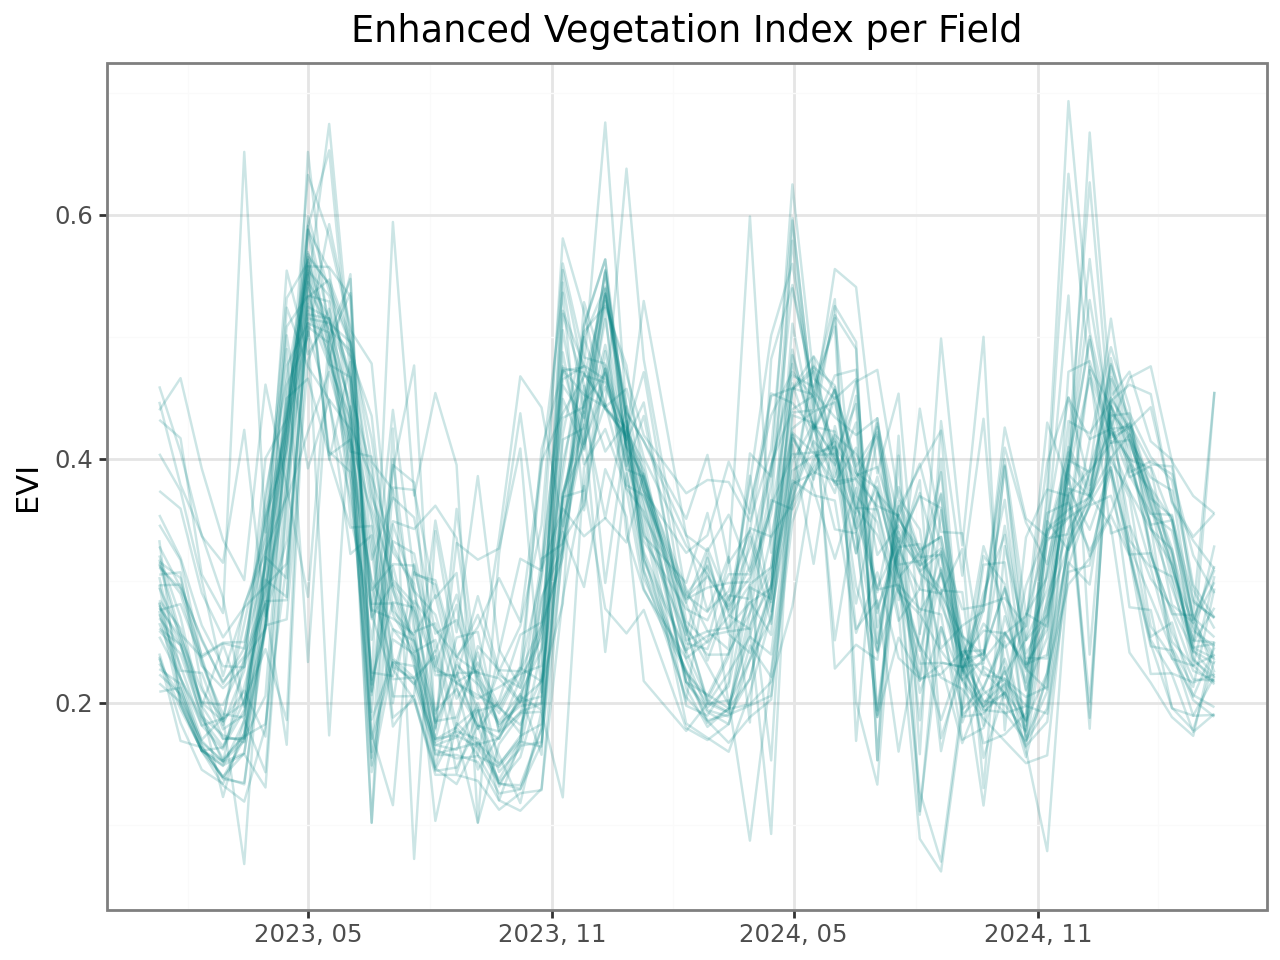

In [22]:
(
    ggplot(df_re, aes(x="date", y="evi", group="id"))
    + geom_line(alpha=0.20, color="teal")
    + labs(x="", y="EVI", title="Enhanced Vegetation Index per Field")
    + scale_x_datetime(
        breaks=date_breaks(width="6 months"), labels=date_format("%Y, %m")
    )
    + theme(figure_size=(10, 6), legend_position="none")
    + theme_bw()
    # + scale_color_brewer(palette='Greens')
)

### Option B: Submit a task  
Output: csv table on Google Drive   
*Recommended for big areas / high n*

In [28]:
gaul_adm1 = ee.FeatureCollection("projects/sat-io/open-datasets/FAO/GAUL/GAUL_2024_L1")

In [29]:
AOIs_AFR = gaul_adm1.filterMetadata("continent", "equals", "Africa")

In [30]:
zs = ZonalStats(
    collection_id="UCSB-CHG/CHIRPS/PENTAD",
    target_features=AOIs_AFR,
    statistic_type="mean",
    frequency="annual",
    temporal_stat="sum",
    scale=5000,
    output_dir="africa",
    output_name="precipitation",
)

In [31]:
zs.runZonalStats()

In [ ]:
zs.task.status

In [34]:
zs.reportRunTime()

Completed
Runtime: 0 minutes and 25 seconds
